In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from class_names import classNames
import random
from vit_traffic import *
import torchvision.transforms as transforms

In [2]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    return total_loss / len(val_loader), 100. * correct / total

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [22]:
batch_size = 64
learning_rate = 1e-4
num_epochs = 50
n_classes = 43

In [23]:
print("Loading datasets...")
train_dataset = TrafficSignDataset('data/train.p')
val_dataset = TrafficSignDataset('data/valid.p')
test_dataset = TrafficSignDataset('data/test.p')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading datasets...
Train samples: 34799
Validation samples: 4410
Test samples: 12630


In [24]:
model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=192,
        n_heads=8,
        hidden_dim=768,
        n_layers=6, 
        n_classes=n_classes,
        dropout=0.1
    ).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 2,699,947


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [26]:
best_val_acc = 0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

MODEL_DIR = 'model'
os.makedirs(MODEL_DIR, exist_ok=True)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, os.path.join(MODEL_DIR, 'best_vit_model.pth'))
        print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')

print('\nEvaluating on test set...')
checkpoint = torch.load(os.path.join(MODEL_DIR, 'best_vit_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch 1/50
--------------------------------------------------
Batch 0/544, Loss: 3.9152, Acc: 1.56%
Batch 50/544, Loss: 3.4294, Acc: 5.36%
Batch 100/544, Loss: 3.4428, Acc: 6.73%
Batch 150/544, Loss: 3.4846, Acc: 7.05%
Batch 200/544, Loss: 3.2355, Acc: 7.61%
Batch 250/544, Loss: 3.2462, Acc: 8.35%
Batch 300/544, Loss: 3.2057, Acc: 9.00%
Batch 350/544, Loss: 2.9246, Acc: 9.51%
Batch 400/544, Loss: 3.1580, Acc: 10.08%
Batch 450/544, Loss: 2.9805, Acc: 10.85%
Batch 500/544, Loss: 2.6592, Acc: 12.24%
Train Loss: 3.1847, Train Acc: 13.60%
Val Loss: 2.3532, Val Acc: 34.17%
Learning Rate: 0.000100
New best model saved with validation accuracy: 34.17%

Epoch 2/50
--------------------------------------------------
Batch 0/544, Loss: 2.3339, Acc: 40.62%
Batch 50/544, Loss: 1.8872, Acc: 34.68%
Batch 100/544, Loss: 2.3713, Acc: 36.06%
Batch 150/544, Loss: 1.9323, Acc: 37.60%
Batch 200/544, Loss: 2.2420, Acc: 38.67%
Batch 250/544, Loss: 1.6662, Acc: 40.48%
Batch 300/544, Loss: 1.6025, Acc: 42.18%


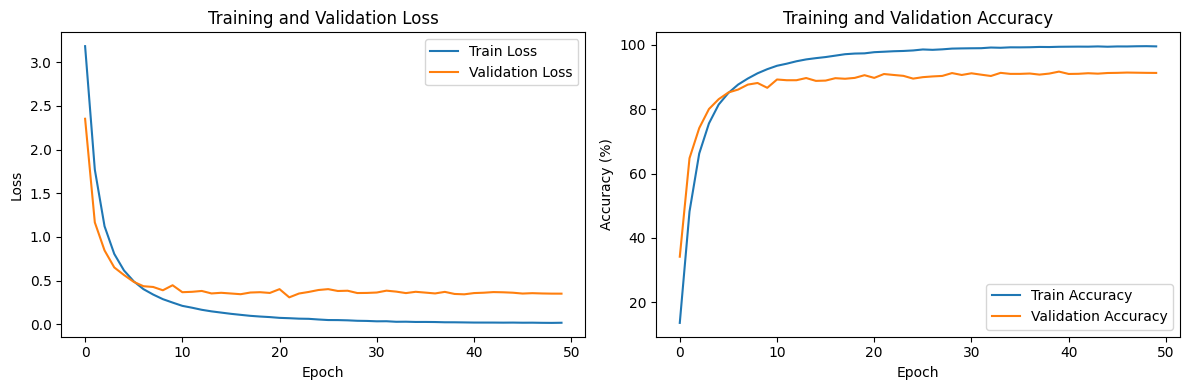

In [27]:
IMAGE_DIR = 'images'
os.makedirs(IMAGE_DIR, exist_ok=True)

plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGE_DIR, 'training_curves.png'))
plt.show()

In [28]:
model_path = 'best_vit_model.pth'

MODEL_DIR = 'model'
os.makedirs(MODEL_DIR, exist_ok=True)

checkpoint = torch.load(os.path.join(MODEL_DIR, model_path), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_iter = iter(test_loader)
images, labels = next(data_iter) 
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    preds = outputs.argmax(dim=1)   

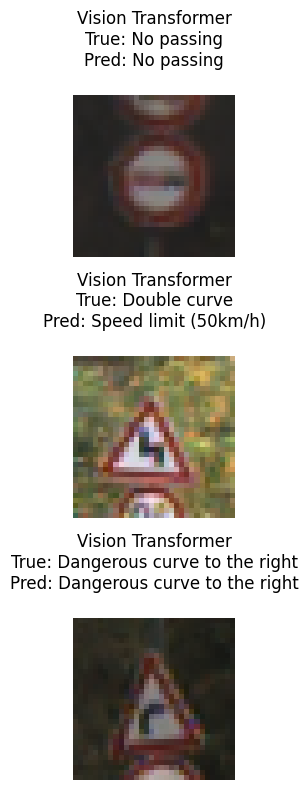

In [29]:
plt.figure(figsize=(12, 8))
x = 15
for i in range(x, 3+x):
    plt.subplot(3, 1, i + 1-x)
    
    pred_label = preds[i].item()
    true_label = labels[i].item()

    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(
        "Vision Transformer\n"
        f'True: {classNames[true_label]}\n'
        f'Pred: {classNames[pred_label]}\n'
    )
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)         
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc   = accuracy_score(all_labels, all_preds)
prec  = precision_score(all_labels, all_preds, average='weighted')
rec   = recall_score(all_labels, all_preds, average='weighted')
f1    = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1‑score      : {f1:.4f}")

Test Accuracy : 0.9171
Precision     : 0.9205
Recall        : 0.9171
F1‑score      : 0.9169
